In [0]:
from fastai.vision import *
import pandas as pd
import os
SPECT_FOLDER = '/content/drive/My Drive/sleep_spectograms/'
SEED = 42

In [0]:
LABELS = ['apnea', 'pos_change', 'breathing/nothing']

def get_label(path: str) -> str:
  real_path = path.parts if isinstance(path, Path) else path.split(os.path.sep)
  for label in LABELS:
    if label in real_path[-1]:
      return label
  return 'breathing/nothing'

In [0]:
def is_valid(path: str):
  """
  Due to the way I did data augmentation, (Rolling Window of 5seconds),
  we must take care not to put files from the same clip in both train & valid,
  because each 1 second frame is repeated in 5 shifted clips
  """
  real_path = path.parts if isinstance(path, Path) else path.split(os.path.sep)
  name = real_path[-1]
  parts = name.split('-')
  if 'apnea' in name and len(parts) == 3:
      return not bool(int(parts[1]) % 5)
  if 'pos_change' in name and len(parts) == 3:
      return parts[1] in ['12', '13', '18']
  if 'breathing' in name and len(parts) == 3:
      return parts[1] in ['6', '8', '11']
  if 'nothing' in name:
      return int(parts[2].replace('.png', '')) < 10
  return False
    

In [0]:
np.random.seed(SEED)
path = Path(SPECT_FOLDER)
path.ls()

data = (ImageList.from_folder(path)
          .split_by_valid_func(is_valid)
          .label_from_func(get_label)
          .databunch()
          .normalize(imagenet_stats))

In [49]:
print(data.classes, data.c, len(data.train_ds), len(data.valid_ds))

['apnea', 'breathing/nothing', 'pos_change'] 3 3297 773


In [50]:
pd.value_counts(data.train_dl.y), pd.value_counts(data.valid_dl.y)

(breathing/nothing    2326
 apnea                 911
 pos_change             60
 dtype: int64, breathing/nothing    484
 apnea                272
 pos_change            17
 dtype: int64)

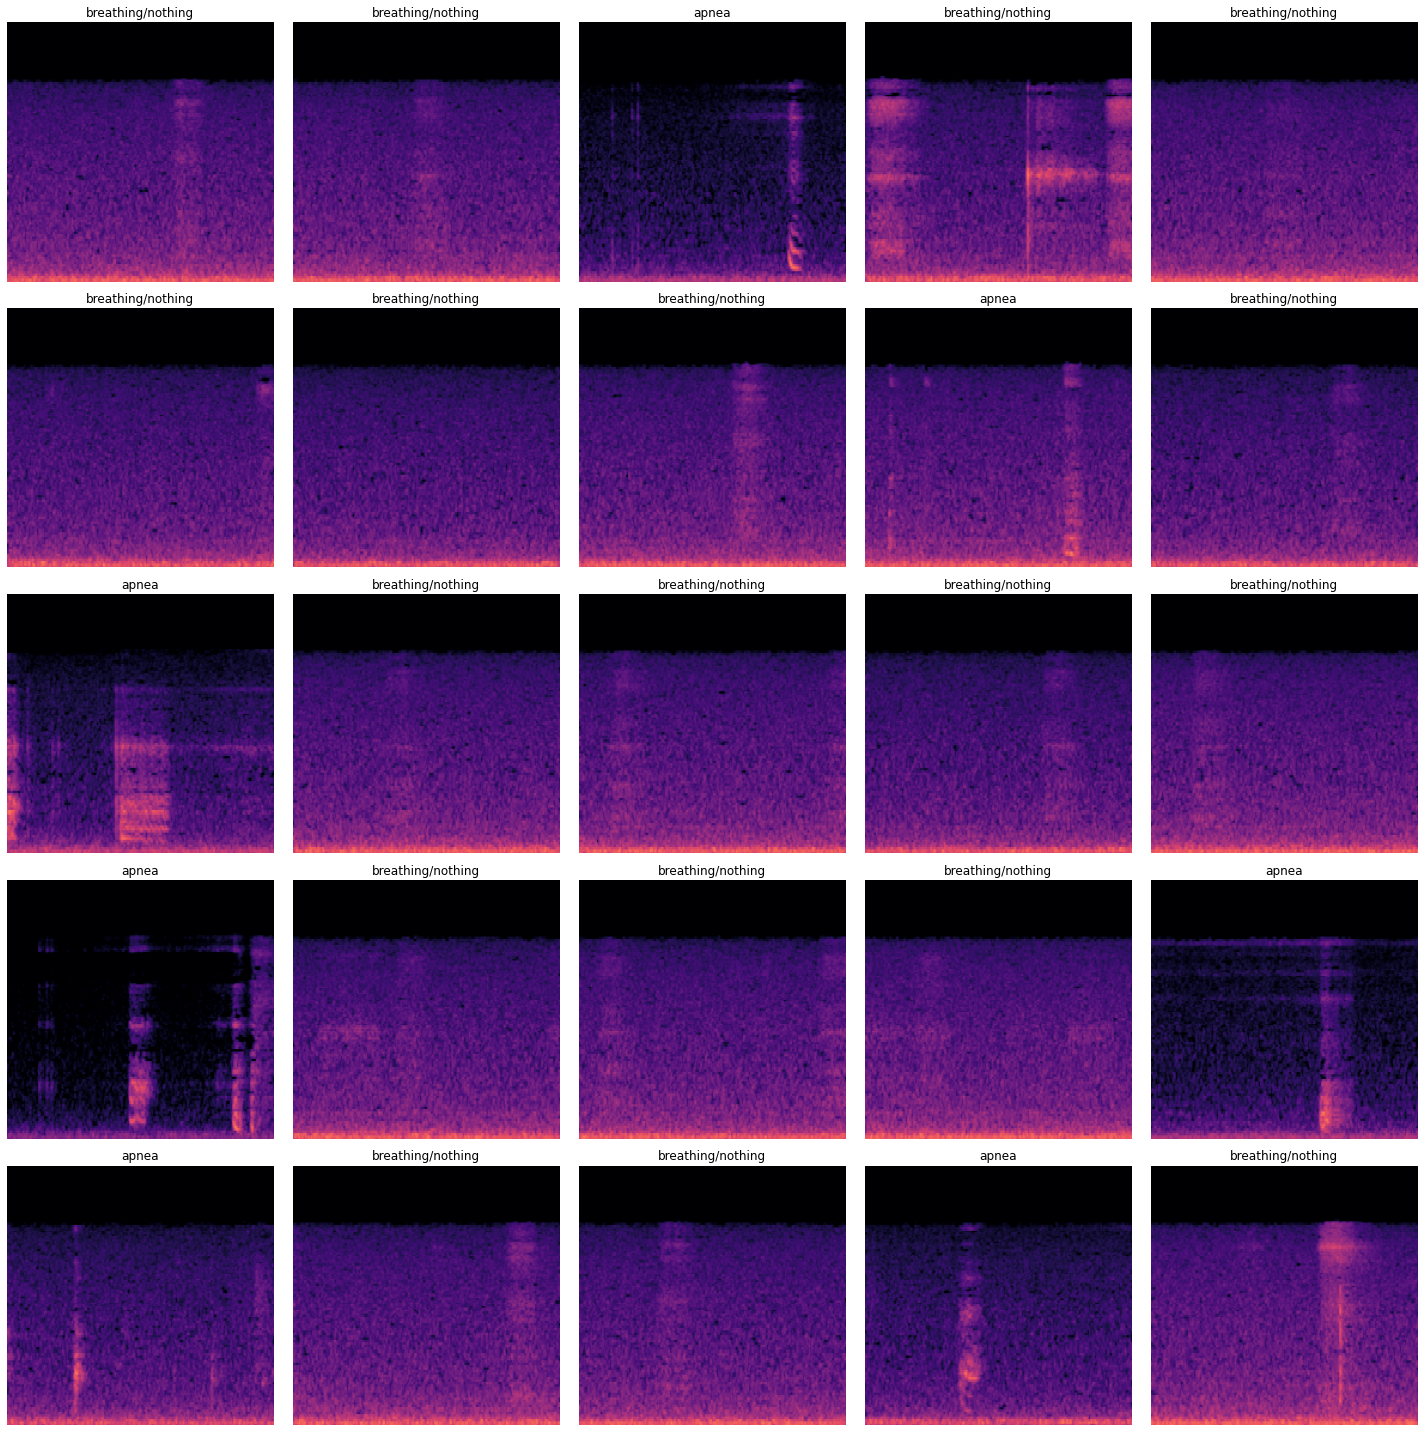

In [51]:
data.show_batch()

In [52]:
from fastai.metrics import error_rate # 1 - accuracy
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
defaults.device = torch.device('cuda') # makes sure the gpu is used

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [53]:
learn.fit_one_cycle(4)
learn.unfreeze() # must be done before calling lr_find

epoch,train_loss,valid_loss,error_rate,time
0,0.705059,0.248408,0.071151,24:57
1,0.333729,0.165371,0.055627,00:34
2,0.167250,0.139336,0.046572,00:27
3,0.099484,0.151217,0.050453,00:26


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


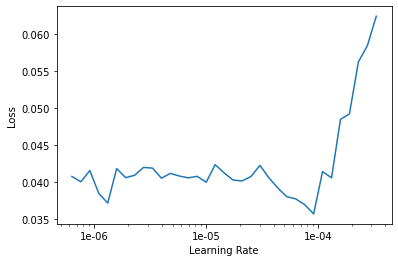

In [54]:
learn.lr_find()
learn.recorder.plot()

In [0]:
 from fastai.callbacks import SaveModelCallback

In [56]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-4), callbacks=[SaveModelCallback(learn, every='epoch', monitor='error_rate', name='model')])

epoch,train_loss,valid_loss,error_rate,time
0,0.050479,0.109398,0.040103,00:37
1,0.037019,0.093140,0.032342,00:38
2,0.022697,0.072825,0.025873,00:37
3,0.016463,0.065226,0.023286,00:37
4,0.010425,0.062065,0.021992,00:37


In [57]:
learn.fit_one_cycle(5, max_lr=slice(5e-6, 5e-5), callbacks=[SaveModelCallback(learn, every='epoch', monitor='error_rate', name='model')])

epoch,train_loss,valid_loss,error_rate,time
0,0.003922,0.072054,0.023286,00:37
1,0.008276,0.081681,0.028461,00:37
2,0.008086,0.065857,0.023286,00:37
3,0.004870,0.059618,0.021992,00:37
4,0.003927,0.058219,0.019405,00:38


In [62]:
learn.fit_one_cycle(5, max_lr=slice(5e-6, 5e-5), callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate', name='model')])

epoch,train_loss,valid_loss,error_rate,time
0,0.002011,0.053851,0.019405,00:37
1,0.002269,0.059576,0.015524,00:37
2,0.004239,0.058971,0.018111,00:37
3,0.003092,0.060643,0.019405,00:38
4,0.003296,0.059921,0.019405,00:37


Better model found at epoch 0 with error_rate value: 0.01940491609275341.


In [0]:
best = learn.load("/content/drive/My Drive/sleep_spectograms/models/model_4")

In [64]:
interp = ClassificationInterpretation.from_learner(best)

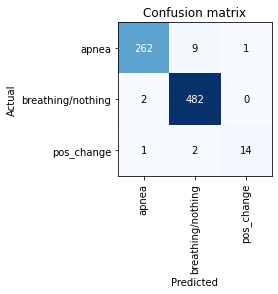

In [60]:
interp.plot_confusion_matrix()


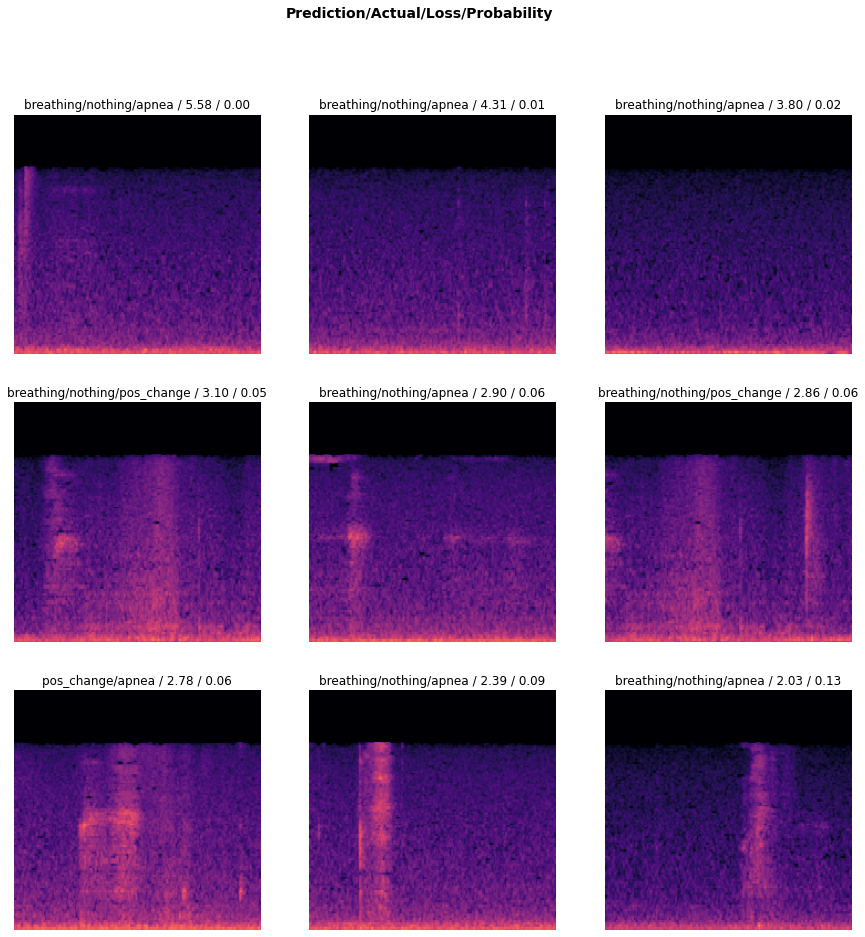

In [61]:
interp.plot_top_losses(9, figsize=(15,15))
